## Practical 3c - Using Spark SQL for Data Preparation (Extra)
In this exercise, we shall illustrate how to generate the various visualizations covered in the lecture programmatically using Python using the dataset `ccFraud.csv.gz` from P03a. Recall that the dataset contains the following fields (each separated by a comma):

```
custID: A unique identifier for each customer
gender: Gender of the customer
state: State in the United States where the customer lives
cardholder: Number of credit cards the customer holds
balance: Balance on the credit card
numTrans: Number of transactions to date
numIntlTrans: Number of international transactions to date
creditLine: The financial services corporation, such as Visa, MasterCard, and American Express
fraudRisk: Binary variable, 1 means customer being frauded, 0 means otherwise
```
Again, let us start by loading the dataset:
```python
fraudDF = spark.read.csv("/home/training/data/ccFraud.csv.gz", inferSchema=True, header=True)
```

In [1]:
fraudDF = spark.read.csv("/home/training/data/ccFraud.csv.gz", inferSchema=True, header=True)

We shall be using the `matplotlib` library as well as several other libraries to generate the various types of data visualizations. Let us start by loading the relevant modules and setting them up as follows:
```
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
```

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Mosaic Plot
In P03a, we created a simple histogram using the `balance` feature. Besides looking at individual features, it would be good to examine the interactions between features. However, trying to plot billions of observations at the same time would be highly impractical and in such cases, it would be better to work with a sample of the data instead. Let us create a sample of the dataset at 0.02% (roughly 2000 observations). We will use the `sampleBy` method which will perform stratified sampling. Here is how we do it:
```python
fraud_sample = fraudDF.sampleBy('gender', fractions={1: 0.0002, 2: 0.0002})
```
There will be two stratum or subgroups, one subgroup represents the male while the other the female. We apply the same sampling faction (0.0002) to each subgroup to create our final sample.

In [3]:
fraud_sample = fraudDF.sampleBy('gender', fractions={1: 0.0002, 2: 0.0002})

Now, let us create a mosaic plot to see the interaction between gender and fraud risk. We will use the `statsmodels` library because it provides the functionality to create a mosaic plot directly.
```python
from statsmodels.graphics import mosaicplot

# first, we generate a dictionary containing the number of records for each combination of gender and fraudRisk
dict = {}
data = fraud_sample.select("gender", "fraudRisk").groupby("gender", "fraudRisk").count().collect()
for row in data:
    d = row.asDict()
    key = (d["gender"], d["fraudRisk"])
    value = d["count"]
    dict[key] = value

# second, we display the mosaic plot
plt.figure(figsize=(7,7))                                              # set figure size
ax = plt.gca()                                                         # get the plotting area
ax.set_xlabel('Gender', fontsize=12, fontweight='semibold')            # set label for x-axis
ax.set_ylabel('Fraud Risk', fontsize=12, fontweight='semibold')        # set label for y-axis
mosaicplot.mosaic(dict, gap=0.05, title='gender vs fraud risk', ax=ax) # generate mosaic plot
plt.show()                                                             # display the figure
```
Notice that the horizontal splits occur at similar locations on the y-axis indicating no strong relationship exists between gender and fraud risk. However, you should not automatically exclude features whose visualizations do not show clear associations with the target variable. These features could still carry a strong association with the target when used in association with other input features.

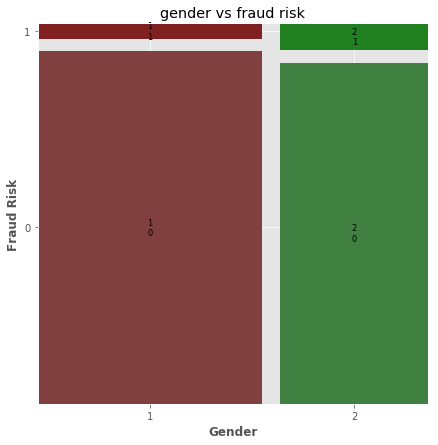

In [4]:
from statsmodels.graphics import mosaicplot

# first, we generate a dictionary containing the number of records for each combination of gender and fraudRisk
dict = {}
data = fraud_sample.select("gender", "fraudRisk").groupby("gender", "fraudRisk").count().collect()
for row in data:
    d = row.asDict()
    key = (d["gender"], d["fraudRisk"])
    value = d["count"]
    dict[key] = value

# second, we display the mosaic plot
plt.figure(figsize=(7,7))                                              # set figure size
ax = plt.gca()                                                         # get the plotting area
ax.set_xlabel('Gender', fontsize=12, fontweight='semibold')            # set label for x-axis
ax.set_ylabel('Fraud Risk', fontsize=12, fontweight='semibold')        # set label for y-axis
mosaicplot.mosaic(dict, gap=0.05, title='gender vs fraud risk', ax=ax) # generate mosaic plot
plt.show()

### Box Plot
Next, we shall create a box plot to visualize the difference in the distribution of `numTrans` as a function of the various categories of the `fraudRisk` feature. However, this time, we shall use the `seaborn` library which is another Python visualization library.
```python
import seaborn as sns

ax = sns.boxplot(x="fraudRisk", y="numTrans", data=fraud_sample.toPandas())
ax.set_xlabel("Fraud Risk")
ax.set_ylabel("Number of Transactions")
plt.show()
```
To generate the box plot, we need to convert our DataFrame `fraud_sample` into a Python Panda (Python's equivalent of a DataFrame) and specify the features we want to use for the x and y axis. We also set the x and y axis labels as well.

From the box plot, we can see that the number of transactions has an obvious relationship with fraud risk: customers with a higher number of transactions have a higher chance of being frauded.

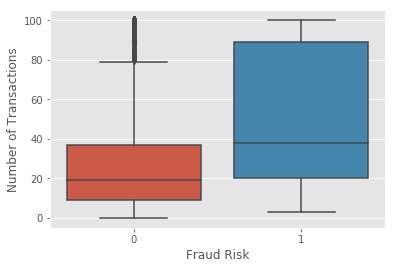

In [5]:
import seaborn as sns

ax = sns.boxplot(x="fraudRisk", y="numTrans", data=fraud_sample.toPandas())
ax.set_xlabel("Fraud Risk")
ax.set_ylabel("Number of Transactions")
plt.show()

### Density Plot
Next, we shall build a density plot to show the distribution of the number of transactions for each gender (ignore any warnings generated).
```python
mlist = [e[0] for e in fraud_sample.select("numTrans").where("gender = 1").collect()]
flist = [e[0] for e in fraud_sample.select("numTrans").where("gender = 2").collect()]
ax = sns.distplot(mlist, hist=False, label="Male")
ax = sns.distplot(flist, hist=False, label="Female")
ax.set_xlabel("Number of Transactions")
ax.set_ylabel("Density")
plt.show()
```
We start by generating a list containing the number of transactions by each male customer followed by another list containing the number of transactions by each female customer. From the graph that is plotted, you will notice that there is no significant difference between the number of transactions made by male or female customers.

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


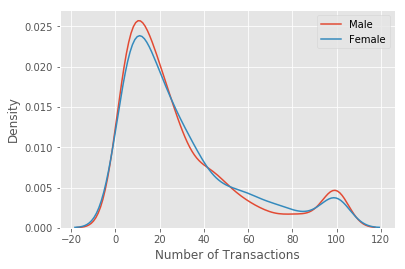

In [6]:
mlist = [e[0] for e in fraud_sample.select("numTrans").where("gender = 1").collect()]
flist = [e[0] for e in fraud_sample.select("numTrans").where("gender = 2").collect()]
ax = sns.distplot(mlist, hist=False, label="Male")
ax = sns.distplot(flist, hist=False, label="Female")
ax.set_xlabel("Number of Transactions")
ax.set_ylabel("Density")
plt.show()

### Scatter Plot
Lastly, we shall create a scatter plot to show the relationship between `balance` and `numTrans`.
```python
ax = sns.regplot(x="balance", y="numTrans", data=fraud_sample.select("balance", "numTrans").toPandas(), 
                 fit_reg=False)
ax.set_xlabel("Balance")
ax.set_ylabel("Number of Transactions")
plt.show()
```
As you can see, there are many transactions that had 0 balance (a fresh card). These transactions are likely to be fraudulent. However, no specific pattern can be shown apart from some _banding_ occuring at $1000 intervals.

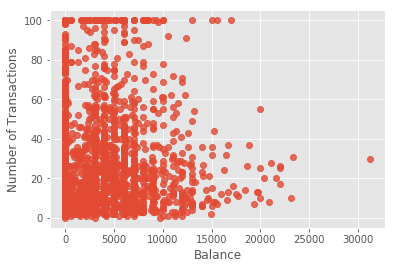

In [7]:
ax = sns.regplot(x="balance", y="numTrans", data=fraud_sample.select("balance", "numTrans").toPandas(), 
                 fit_reg=False)
ax.set_xlabel("Balance")
ax.set_ylabel("Number of Transactions")
plt.show()